# ch3 决策树
## 3.1 Tree construction

In [83]:
from collections import Counter
from math import log
import matplotlib.pyplot as plt

### 计算香农熵

In [47]:
def calc_shannon_ent(dataset):
    """计算数据集的香农熵"""
    num_entries = len(dataset)
    label_counts = Counter()
    for feat_vec in dataset:
        current_label = feat_vec[-1]
        label_counts[current_label] += 1
    shannon_ent = 0
    for count in label_counts.values():
        prob = count / num_entries
        shannon_ent -= prob * log(prob, 2)
    return shannon_ent

def create_dataset():
    dataset = [[1, 1, 'y'],
               [1, 1, 'y'],
               [1, 0, 'n'],
               [0, 1, 'n'],
               [0, 1, 'n']]
    labels = ['feature A', 'feature B']
    return dataset, labels

dataset, _ = create_dataset()
calc_shannon_ent(dataset)

0.9709505944546686

In [40]:
# 增加分类使熵增大
dataset[0][-1] = 'maybe'
calc_shannon_ent(dataset)

1.3709505944546687

### 划分数据集

In [129]:
def split_dataset(dataset, axis, value):
    """得到第 axis 个 feature 取值为 value 的子数据集"""
    return_dataset = []
    for feat_vec in dataset:
        if feat_vec[axis] == value:
            reduced_feat_vec = feat_vec[:axis]
            reduced_feat_vec.extend(feat_vec[axis+1:])
            return_dataset.append(reduced_feat_vec)
    return return_dataset

my_data, labels = create_dataset()

# feature A 为 1 的数据子集
split_dataset(my_data, 0, 1)

[[1, 'y'], [1, 'y'], [0, 'n']]

### 选择最好的数据集划分方式

In [50]:
def choose_best_feature_to_split(dataset):
    num_features = len(dataset[0]) - 1
    base_entropy = calc_shannon_ent(dataset)
    best_info_gain = 0
    best_feature = -1
    
    for i in range(num_features):
        feat_list = [example[i] for example in dataset]
        unique_vals = set(feat_list)
        new_entropy = 0
        
        # 计算特征i的信息增益 (可参考统计学习方法 ch5.2.2)
        for val in unique_vals:
            sub_dataset = split_dataset(dataset, i, val)
            prob = len(sub_dataset) / len(dataset)
            new_entropy += prob * calc_shannon_ent(sub_dataset)
        info_gain = base_entropy - new_entropy
        
        if (info_gain > best_info_gain):
            best_info_gain = info_gain
            best_feature = i
    return best_feature

choose_best_feature_to_split(my_data)

0

### 递归创建树

In [56]:
def majority_cnt(class_list):
    """majority vote"""
    class_count = Counter(class_list)
    return class_count.most_common(1)[0][0]

In [81]:
def create_tree(dataset, labels):
    class_list = [example[-1] for example in dataset]
    
    # 停止条件1: 节点处所有样本属于同一分类
    if class_list.count(class_list[0]) == len(class_list):
        return class_list[0]
    
    # 停止条件2: 特征已经"用完"
    if len(dataset[0]) == 1:
        return majority_cnt(class_list)
    
    best_feat = choose_best_feature_to_split(dataset)
    best_feat_label = labels[best_feat]
    tree = {best_feat_label: {}}  # 这里简单地用字典实现, 也可用特殊的数据结构
    del(labels[best_feat])
    feat_vals = [example[best_feat] for example in dataset]
    unique_vals = set(feat_vals)
    for val in unique_vals:
        sub_labels = labels[:]
        tree[best_feat_label][val] = create_tree(
            split_dataset(dataset, best_feat, val), sub_labels)
    return tree

tree = create_tree(my_data, labels)
tree

{'feature A': {0: 'n', 1: {'feature B': {0: 'n', 1: 'y'}}}}

## 3.2 Plotting trees
### matplotlib annotations

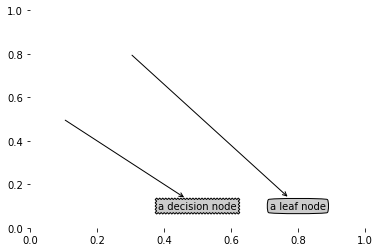

In [116]:
# define box and array formatting
decision_node = dict(boxstyle='sawtooth', fc='0.8')
leaf_node = dict(boxstyle='round4', fc='0.8')
arrow_args = dict(arrowstyle='<-')

def plot_node(node_txt, center_pt, parent_pt, node_type):
    """draw annotations with arrows"""
    create_plot.ax1.annotate(node_txt, xy=parent_pt, xycoords='axes fraction',
                             xytext=center_pt, textcoords='axes fraction',
                             va='center', ha='center', bbox=node_type, arrowprops=arrow_args)

def create_plot():
    fig = plt.figure(1, facecolor='white')
    fig.clf()
    create_plot.ax1 = plt.subplot(111, frameon=False)
    plot_node('a decision node', (0.5, 0.1), (0.1, 0.5), decision_node)
    plot_node('a leaf node', (0.8, 0.1), (0.3, 0.8), leaf_node)
    plt.show()
    
create_plot()

`create_plot.ax1` 这样定义全局变量的方法还是第一次见.

### constructing a tree of annotations

In [128]:
def get_num_leafs(tree):
    num_leafs = 0
    first_str = list(tree.keys())[0]
    second_dict = tree[first_str]
    for val in second_dict.values():
        if type(val).__name__ == 'dict':  # 是否有更好的做法?
            num_leafs += get_num_leafs(val)
        else:
            num_leafs += 1
    return num_leafs

def get_tree_depth(tree):
    max_depth = 0
    first_str = list(tree.keys())[0]
    second_dict = tree[first_str]
    for val in second_dict.values():
        if type(val).__name__ == 'dict':
            this_depth = 1 + get_tree_depth(val)
        else:
            this_depth = 1
        if this_depth > max_depth:
            max_depth = this_depth
    return max_depth

get_num_leafs(tree), get_tree_depth(tree)

(3, 2)

In [132]:
def plot_mid_text(center_pt, parent_pt, txt):
    x_mid = (parent_pt[0] - center_pt[0]) / 2 + center_pt[0]
    y_mid = (parent_pt[1] - center_pt[1]) / 2 + center_pt[1]
    create_plot.ax1.text(x_mid, y_mid, txt)

def plot_tree(tree, parent_pt, node_txt):
    num_leafs = get_num_leafs(tree)
    get_tree_depth(tree)
    first_str = list(tree.keys())[0]
    center_pt = (plot_tree.xoff + (1.0 + num_leafs) / 2 / plot_tree.total_w, plot_tree.yoff)
    plot_mid_text(center_pt, parent_pt, node_txt)
    plot_node(first_str, center_pt, parent_pt, decision_node)
    second_dict = tree[first_str]
    plot_tree.yoff = plot_tree.yoff - 1 / plot_tree.total_d
    for key, val in second_dict.items():
        if type(val).__name__ == 'dict':
            plot_tree(val, center_pt, str(key))
        else:
            plot_tree.xoff = plot_tree.xoff + 1 / plot_tree.total_w
            plot_node(val, (plot_tree.xoff, plot_tree.yoff), center_pt, leaf_node)
            plot_mid_text((plot_tree.xoff, plot_tree.yoff), center_pt, str(key))
    plot_tree.yoff = plot_tree.yoff + 1 / plot_tree.total_d

def create_plot(in_tree):
    fig = plt.figure(1, facecolor='white')
    fig.clf()
    axprops = dict(xticks=[], yticks=[])
    create_plot.ax1 = plt.subplot(111, frameon=False, **axprops)
    plot_tree.total_w = get_num_leafs(in_tree)
    plot_tree.total_d = get_tree_depth(in_tree)
    plot_tree.xoff = -0.5 / plot_tree.total_w
    plot_tree.yoff = 1.0
    plot_tree(in_tree, (0.5, 1.0), '')
    plt.show()
    

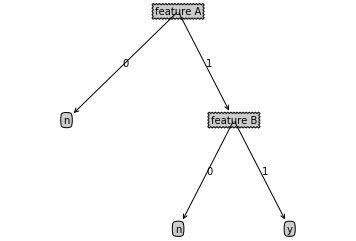

In [133]:
create_plot(tree)

## 3.3 testing and storing the classifier
### use the tree for classification

In [138]:
def classify(input_tree, feat_labels, test_vec):
    first_str = list(input_tree.keys())[0]
    second_dict = input_tree[first_str]
    feat_index = feat_labels.index(first_str)
    for key, val in second_dict.items():
        if test_vec[feat_index] == key:
            if type(val).__name__ == 'dict':
                class_label = classify(val, feat_labels, test_vec)
            else:
                class_label =val
    return class_label

classify(tree, labels, [1, 0])

'n'

### persisting the decision tree
use `pickle` to serialize objects  
注意 Python 3 中需要使用 'wb' 和 'rb' 模式

In [141]:
def store_tree(input_tree, filename):
    import pickle
    fw = open(filename, 'wb')
    pickle.dump(input_tree, fw)
    fw.close()

def grab_tree(filename):
    import pickle
    fr = open(filename, 'rb')
    return pickle.load(fr)

store_tree(tree, '^classifier_storage.txt')
grab_tree('^classifier_storage.txt')

{'feature A': {0: 'n', 1: {'feature B': {0: 'n', 1: 'y'}}}}

## 3.4 example
预测患者需要佩戴的隐形眼镜类型

In [142]:
!head -10 lenses.txt

young	myope	no	reduced	no lenses
young	myope	no	normal	soft
young	myope	yes	reduced	no lenses
young	myope	yes	normal	hard
young	hyper	no	reduced	no lenses
young	hyper	no	normal	soft
young	hyper	yes	reduced	no lenses
young	hyper	yes	normal	hard
pre	myope	no	reduced	no lenses
pre	myope	no	normal	soft


In [145]:
fr = open('lenses.txt')
lenses = [line.strip().split('\t') for line in fr.readlines()]
lenses_labels = ['age', 'prescript', 'astigmatic', 'tearRate']
lenses_tree = create_tree(lenses, lenses_labels)
lenses_tree

{'tearRate': {'normal': {'astigmatic': {'no': {'age': {'pre': 'soft',
      'presbyopic': {'prescript': {'hyper': 'soft', 'myope': 'no lenses'}},
      'young': 'soft'}},
    'yes': {'prescript': {'hyper': {'age': {'pre': 'no lenses',
        'presbyopic': 'no lenses',
        'young': 'hard'}},
      'myope': 'hard'}}}},
  'reduced': 'no lenses'}}

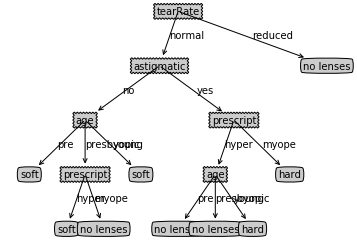

In [146]:
create_plot(lenses_tree)

## 小结

* 本章采用 ID3 算法, 特征选择和分支创建依据信息增益准则. 该算法只能处理 nominal 数据, 无法处理 numerical 数据.
* 递归方法在决策树的生成, 绘制和预测中都很有用.
* 用 matplotlib 绘制决策树.
* 本章未涉及决策树剪枝.